Здесь обработка данных письма с планшета.

In [88]:
from ev_parser import gesture_parser
from ev_parser import gesture_parser
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from functools import partial
import warnings
warnings.filterwarnings('ignore')

## Извлекаем данные

In [91]:
subject='S105'

In [93]:
code='5'

### Записи с планшета для S101

In [18]:
filename = subject+'/HW_S101/2023-04-04_19-09-19_.gesture'

### Записи с планшета для S104

In [59]:
filename = subject+'/2023-04-11_15-56-53_.gesture'

In [139]:
filename = subject+'/2023-04-11_16-04-54_.gesture'

In [221]:
filename = subject+'/2023-04-11_16-12-36_.gesture'

In [301]:
filename = subject+'/2023-04-11_16-20-32_.gesture'

In [382]:
filename = subject+'/2023-04-11_16-28-18_.gesture'

### Записи с планшета для S105

In [622]:
filename = subject+'/2023-04-21_14-44-05_.gesture'

In [544]:
filename = subject+'/2023-04-21_14-51-48_.gesture'

In [702]:
filename = subject+'/2023-04-21_14-59-39_.gesture'

In [782]:
filename = subject+'/2023-04-21_15-07-18_.gesture'

In [95]:
filename = subject+'/2023-04-21_15-15-03_.gesture'

### Форматирование

In [98]:
filename

'S105/2023-04-21_15-15-03_.gesture'

In [100]:
gesture_name = filename
skiprows=22

Извлекаем данные пьсма на планшете из .gesture. Приводим табличку к нужному виду: форматируем, добавляем подписи столбцов.

In [103]:
df_gesture = pd.read_csv(gesture_name, header=None, delim_whitespace=True, skiprows=skiprows)
assert((df_gesture[0]=='[').all()) #проверка, что все строки содержат скобку в начале - проверка формата
df_gesture.drop(columns=[0], inplace=True)
df_gesture['ts'] = df_gesture[1].str.replace(']', '').astype('float')
df_gesture.rename(columns={2:'INPUT', 3:'TYPE', 4:'KEY', 5:'VALUE'}, inplace=True)
df_gesture.ts -= df_gesture.ts.min() #сдвигаем, чтобы отсчет шел с 0

In [105]:
df_gesture

,1,INPUT,TYPE,KEY,VALUE,ts
0,2740.250921],/dev/input/event0:,EV_ABS,ABS_MT_SLOT,00000000,0.000000
1,2740.250921],/dev/input/event0:,EV_ABS,ABS_MT_TRACKING_ID,00000000,0.000000
2,2740.250921],/dev/input/event0:,EV_ABS,ABS_MT_POSITION_X,000000dc,0.000000
3,2740.250921],/dev/input/event0:,EV_ABS,ABS_MT_POSITION_Y,00000180,0.000000
4,2740.250921],/dev/input/event0:,EV_ABS,ABS_MT_TOUCH_MAJOR,00000009,0.000000
...,...,...,...,...,...,...
11926,3169.110487],/dev/input/event0:,EV_SYN,SYN_REPORT,00000000,428.859566
11927,3169.803688],/dev/input/event0:,EV_ABS,ABS_MT_TRACKING_ID,00000000,429.552767
11928,3169.803688],/dev/input/event0:,EV_SYN,SYN_REPORT,00000000,429.552767
11929,3169.901306],/dev/input/event0:,EV_ABS,ABS_MT_TRACKING_ID,7fffffff,429.650385


## Отмечаем места, где ставились метки стирания 

Стиранию соответсвует код 7fffffff

In [108]:
df_gesture['Reset'] = False #добавляем столбец для меток 
df_gesture.loc[df_gesture.query('KEY=="ABS_MT_TRACKING_ID" & VALUE=="7fffffff"').index, 'Reset']=True
df_gesture['ResetCounter'] = np.cumsum(df_gesture.Reset) #считаем кол-во стираний
df_gesture

,1,INPUT,TYPE,KEY,VALUE,ts,Reset,ResetCounter
0,2740.250921],/dev/input/event0:,EV_ABS,ABS_MT_SLOT,00000000,0.000000,False,0
1,2740.250921],/dev/input/event0:,EV_ABS,ABS_MT_TRACKING_ID,00000000,0.000000,False,0
2,2740.250921],/dev/input/event0:,EV_ABS,ABS_MT_POSITION_X,000000dc,0.000000,False,0
3,2740.250921],/dev/input/event0:,EV_ABS,ABS_MT_POSITION_Y,00000180,0.000000,False,0
4,2740.250921],/dev/input/event0:,EV_ABS,ABS_MT_TOUCH_MAJOR,00000009,0.000000,False,0
...,...,...,...,...,...,...,...,...
11926,3169.110487],/dev/input/event0:,EV_SYN,SYN_REPORT,00000000,428.859566,False,199
11927,3169.803688],/dev/input/event0:,EV_ABS,ABS_MT_TRACKING_ID,00000000,429.552767,False,199
11928,3169.803688],/dev/input/event0:,EV_SYN,SYN_REPORT,00000000,429.552767,False,199
11929,3169.901306],/dev/input/event0:,EV_ABS,ABS_MT_TRACKING_ID,7fffffff,429.650385,True,200


Выделяем из таблицы только те строки, которые соответсвуют меткам стирания и берем нужные столбцы. 

In [111]:
marks=df_gesture[(df_gesture['Reset']==True)][['INPUT','TYPE','ts','ResetCounter']] 

In [113]:
marks

,INPUT,TYPE,ts,ResetCounter
278,/dev/input/event0:,EV_ABS,2.117363,1
295,/dev/input/event0:,EV_ABS,3.008759,2
299,/dev/input/event0:,EV_ABS,3.922622,3
303,/dev/input/event0:,EV_ABS,4.722857,4
307,/dev/input/event0:,EV_ABS,10.849836,5
...,...,...,...,...
11677,/dev/input/event0:,EV_ABS,421.134296,196
11917,/dev/input/event0:,EV_ABS,427.162432,197
11921,/dev/input/event0:,EV_ABS,428.042772,198
11925,/dev/input/event0:,EV_ABS,428.859566,199


Добавляем столбец с указанием эпохи, к которой принадлежат стирания. В каждой эпохе 4 стирания. Добавляем столбцы координат по Х и по У, задаем им значение -1, этот код будет соответствовать стиранию.

In [116]:
marks['Epoch']=(marks['ResetCounter']-1)//4 

In [118]:
marks['X']=-1
marks['Y']=-1

In [120]:
marks

,INPUT,TYPE,ts,ResetCounter,Epoch,X,Y
278,/dev/input/event0:,EV_ABS,2.117363,1,0,-1,-1
295,/dev/input/event0:,EV_ABS,3.008759,2,0,-1,-1
299,/dev/input/event0:,EV_ABS,3.922622,3,0,-1,-1
303,/dev/input/event0:,EV_ABS,4.722857,4,0,-1,-1
307,/dev/input/event0:,EV_ABS,10.849836,5,1,-1,-1
...,...,...,...,...,...,...,...
11677,/dev/input/event0:,EV_ABS,421.134296,196,48,-1,-1
11917,/dev/input/event0:,EV_ABS,427.162432,197,49,-1,-1
11921,/dev/input/event0:,EV_ABS,428.042772,198,49,-1,-1
11925,/dev/input/event0:,EV_ABS,428.859566,199,49,-1,-1


## Создаем таблицу с данными рукописного ввода. 

Для этого берем те строки, в которых есть ключи для касаний. 

In [123]:
df_motion = df_gesture.query('(KEY == "ABS_MT_POSITION_X") or (KEY == "ABS_MT_POSITION_Y")').copy() #события касаний
df_motion

,1,INPUT,TYPE,KEY,VALUE,ts,Reset,ResetCounter
2,2740.250921],/dev/input/event0:,EV_ABS,ABS_MT_POSITION_X,000000dc,0.000000,False,0
3,2740.250921],/dev/input/event0:,EV_ABS,ABS_MT_POSITION_Y,00000180,0.000000,False,0
10,2740.418867],/dev/input/event0:,EV_ABS,ABS_MT_POSITION_Y,0000017e,0.167946,False,0
12,2740.435600],/dev/input/event0:,EV_ABS,ABS_MT_POSITION_X,000000e5,0.184679,False,0
13,2740.435600],/dev/input/event0:,EV_ABS,ABS_MT_POSITION_Y,0000017d,0.184679,False,0
...,...,...,...,...,...,...,...,...
11902,3165.203612],/dev/input/event0:,EV_ABS,ABS_MT_POSITION_Y,00000279,424.952691,False,196
11904,3165.220494],/dev/input/event0:,EV_ABS,ABS_MT_POSITION_Y,00000277,424.969573,False,196
11906,3165.237219],/dev/input/event0:,EV_ABS,ABS_MT_POSITION_Y,00000276,424.986298,False,196
11908,3165.253989],/dev/input/event0:,EV_ABS,ABS_MT_POSITION_Y,00000275,425.003068,False,196


Добавляем столбец с величиной = координате, переводим в 10-ую систему счисления из 16-ой. 

In [126]:
df_motion.loc[:, 'MAGNITUDE'] = df_motion['VALUE'].apply(partial(int, base=16)) 

In [128]:
df_motion['X'] = None
df_motion['Y'] = None

In [130]:
df_motion

,1,INPUT,TYPE,KEY,VALUE,ts,Reset,ResetCounter,MAGNITUDE,X,Y
2,2740.250921],/dev/input/event0:,EV_ABS,ABS_MT_POSITION_X,000000dc,0.000000,False,0,220,None,None
3,2740.250921],/dev/input/event0:,EV_ABS,ABS_MT_POSITION_Y,00000180,0.000000,False,0,384,None,None
10,2740.418867],/dev/input/event0:,EV_ABS,ABS_MT_POSITION_Y,0000017e,0.167946,False,0,382,None,None
12,2740.435600],/dev/input/event0:,EV_ABS,ABS_MT_POSITION_X,000000e5,0.184679,False,0,229,None,None
13,2740.435600],/dev/input/event0:,EV_ABS,ABS_MT_POSITION_Y,0000017d,0.184679,False,0,381,None,None
...,...,...,...,...,...,...,...,...,...,...,...
11902,3165.203612],/dev/input/event0:,EV_ABS,ABS_MT_POSITION_Y,00000279,424.952691,False,196,633,None,None
11904,3165.220494],/dev/input/event0:,EV_ABS,ABS_MT_POSITION_Y,00000277,424.969573,False,196,631,None,None
11906,3165.237219],/dev/input/event0:,EV_ABS,ABS_MT_POSITION_Y,00000276,424.986298,False,196,630,None,None
11908,3165.253989],/dev/input/event0:,EV_ABS,ABS_MT_POSITION_Y,00000275,425.003068,False,196,629,None,None


Присваиваем координатам Х и У значения magnitude в соответствии с ключом (позиция Х или У). Пустое знаечние заполняем NaN и выкидываем.

In [133]:
mask = df_motion.KEY == 'ABS_MT_POSITION_X'
df_motion.loc[mask, 'X'] = df_motion.loc[mask, 'MAGNITUDE']

mask = df_motion.KEY == 'ABS_MT_POSITION_Y'
df_motion.loc[mask, 'Y'] = df_motion.loc[mask, 'MAGNITUDE']

In [135]:
df_motion.fillna(method='ffill', inplace=True)
df_motion

,1,INPUT,TYPE,KEY,VALUE,ts,Reset,ResetCounter,MAGNITUDE,X,Y
2,2740.250921],/dev/input/event0:,EV_ABS,ABS_MT_POSITION_X,000000dc,0.000000,False,0,220,220,NaN
3,2740.250921],/dev/input/event0:,EV_ABS,ABS_MT_POSITION_Y,00000180,0.000000,False,0,384,220,384.0
10,2740.418867],/dev/input/event0:,EV_ABS,ABS_MT_POSITION_Y,0000017e,0.167946,False,0,382,220,382.0
12,2740.435600],/dev/input/event0:,EV_ABS,ABS_MT_POSITION_X,000000e5,0.184679,False,0,229,229,382.0
13,2740.435600],/dev/input/event0:,EV_ABS,ABS_MT_POSITION_Y,0000017d,0.184679,False,0,381,229,381.0
...,...,...,...,...,...,...,...,...,...,...,...
11902,3165.203612],/dev/input/event0:,EV_ABS,ABS_MT_POSITION_Y,00000279,424.952691,False,196,633,257,633.0
11904,3165.220494],/dev/input/event0:,EV_ABS,ABS_MT_POSITION_Y,00000277,424.969573,False,196,631,257,631.0
11906,3165.237219],/dev/input/event0:,EV_ABS,ABS_MT_POSITION_Y,00000276,424.986298,False,196,630,257,630.0
11908,3165.253989],/dev/input/event0:,EV_ABS,ABS_MT_POSITION_Y,00000275,425.003068,False,196,629,257,629.0


In [137]:
df_motion.dropna(inplace=True)

In [139]:
df_motion

,1,INPUT,TYPE,KEY,VALUE,ts,Reset,ResetCounter,MAGNITUDE,X,Y
3,2740.250921],/dev/input/event0:,EV_ABS,ABS_MT_POSITION_Y,00000180,0.000000,False,0,384,220,384.0
10,2740.418867],/dev/input/event0:,EV_ABS,ABS_MT_POSITION_Y,0000017e,0.167946,False,0,382,220,382.0
12,2740.435600],/dev/input/event0:,EV_ABS,ABS_MT_POSITION_X,000000e5,0.184679,False,0,229,229,382.0
13,2740.435600],/dev/input/event0:,EV_ABS,ABS_MT_POSITION_Y,0000017d,0.184679,False,0,381,229,381.0
15,2740.452504],/dev/input/event0:,EV_ABS,ABS_MT_POSITION_X,000000fe,0.201583,False,0,254,254,381.0
...,...,...,...,...,...,...,...,...,...,...,...
11902,3165.203612],/dev/input/event0:,EV_ABS,ABS_MT_POSITION_Y,00000279,424.952691,False,196,633,257,633.0
11904,3165.220494],/dev/input/event0:,EV_ABS,ABS_MT_POSITION_Y,00000277,424.969573,False,196,631,257,631.0
11906,3165.237219],/dev/input/event0:,EV_ABS,ABS_MT_POSITION_Y,00000276,424.986298,False,196,630,257,630.0
11908,3165.253989],/dev/input/event0:,EV_ABS,ABS_MT_POSITION_Y,00000275,425.003068,False,196,629,257,629.0


Удаляем дубликаты и лишние столбцы. Обновляем индексы. Добавляем значения эпох и открываем файл с цифрами.

In [142]:
df_motion.drop_duplicates(subset=[1], keep='last', inplace=True)
df_motion.reset_index(drop=True, inplace=True)
df_motion.drop(columns=[1, 'TYPE', 'KEY', 'VALUE', 'MAGNITUDE', 'Reset'], inplace=True)

In [144]:
df_motion['Epoch'] = df_motion.ResetCounter//4
df_protocol=pd.read_excel('8_Sessions/Digits_Tyumen_'+code+'.xlsx')

In [146]:
df_motion

,INPUT,ts,ResetCounter,X,Y,Epoch
0,/dev/input/event0:,0.000000,0,220,384.0,0
1,/dev/input/event0:,0.167946,0,220,382.0,0
2,/dev/input/event0:,0.184679,0,229,381.0,0
3,/dev/input/event0:,0.201583,0,254,376.0,0
4,/dev/input/event0:,0.218395,0,279,373.0,0
...,...,...,...,...,...,...
3909,/dev/input/event0:,424.952691,196,257,633.0,49
3910,/dev/input/event0:,424.969573,196,257,631.0,49
3911,/dev/input/event0:,424.986298,196,257,630.0,49
3912,/dev/input/event0:,425.003068,196,257,629.0,49


In [148]:
code

'5'

In [150]:
df_protocol['Digit_text'].values

array([3, 3, 5, 4, 6, 2, 9, 7, 8, 2, 8, 3, 0, 1, 7, 0, 7, 7, 1, 0, 1, 6,
       6, 8, 5, 9, 9, 0, 6, 2, 8, 1, 4, 4, 1, 4, 4, 8, 0, 7, 5, 5, 2, 9,
       9, 5, 3, 2, 6, 3], dtype=int64)

Убираем 0-ую эпоху??????????????????????? если здесь ее не убрать на графиках в 3 скрипте ее все равно нет...

In [153]:
df_motion=df_motion[df_motion['Epoch']>=-1] 

In [155]:
df_motion=df_motion[df_motion['Epoch']<=49]

In [157]:
marks=marks[marks['Epoch']<=49]

In [159]:
marks=marks[marks['Epoch']>=-1]

In [161]:
df_motion

,INPUT,ts,ResetCounter,X,Y,Epoch
0,/dev/input/event0:,0.000000,0,220,384.0,0
1,/dev/input/event0:,0.167946,0,220,382.0,0
2,/dev/input/event0:,0.184679,0,229,381.0,0
3,/dev/input/event0:,0.201583,0,254,376.0,0
4,/dev/input/event0:,0.218395,0,279,373.0,0
...,...,...,...,...,...,...
3909,/dev/input/event0:,424.952691,196,257,633.0,49
3910,/dev/input/event0:,424.969573,196,257,631.0,49
3911,/dev/input/event0:,424.986298,196,257,630.0,49
3912,/dev/input/event0:,425.003068,196,257,629.0,49


In [233]:
marks.head(20)

,INPUT,TYPE,ts,ResetCounter,Epoch,X,Y
278,/dev/input/event0:,EV_ABS,2.117363,1,0,-1,-1
295,/dev/input/event0:,EV_ABS,3.008759,2,0,-1,-1
299,/dev/input/event0:,EV_ABS,3.922622,3,0,-1,-1
303,/dev/input/event0:,EV_ABS,4.722857,4,0,-1,-1
307,/dev/input/event0:,EV_ABS,10.849836,5,1,-1,-1
311,/dev/input/event0:,EV_ABS,11.690964,6,1,-1,-1
315,/dev/input/event0:,EV_ABS,12.570442,7,1,-1,-1
319,/dev/input/event0:,EV_ABS,13.389680,8,1,-1,-1
523,/dev/input/event0:,EV_ABS,19.568382,9,2,-1,-1
527,/dev/input/event0:,EV_ABS,20.482564,10,2,-1,-1


In [165]:
df_protocol

,Digit_text
0,3
1,3
2,5
3,4
4,6
5,2
6,9
7,7
8,8
9,2


## Строим картинки с цифрами, которые рисовал испытуемый.

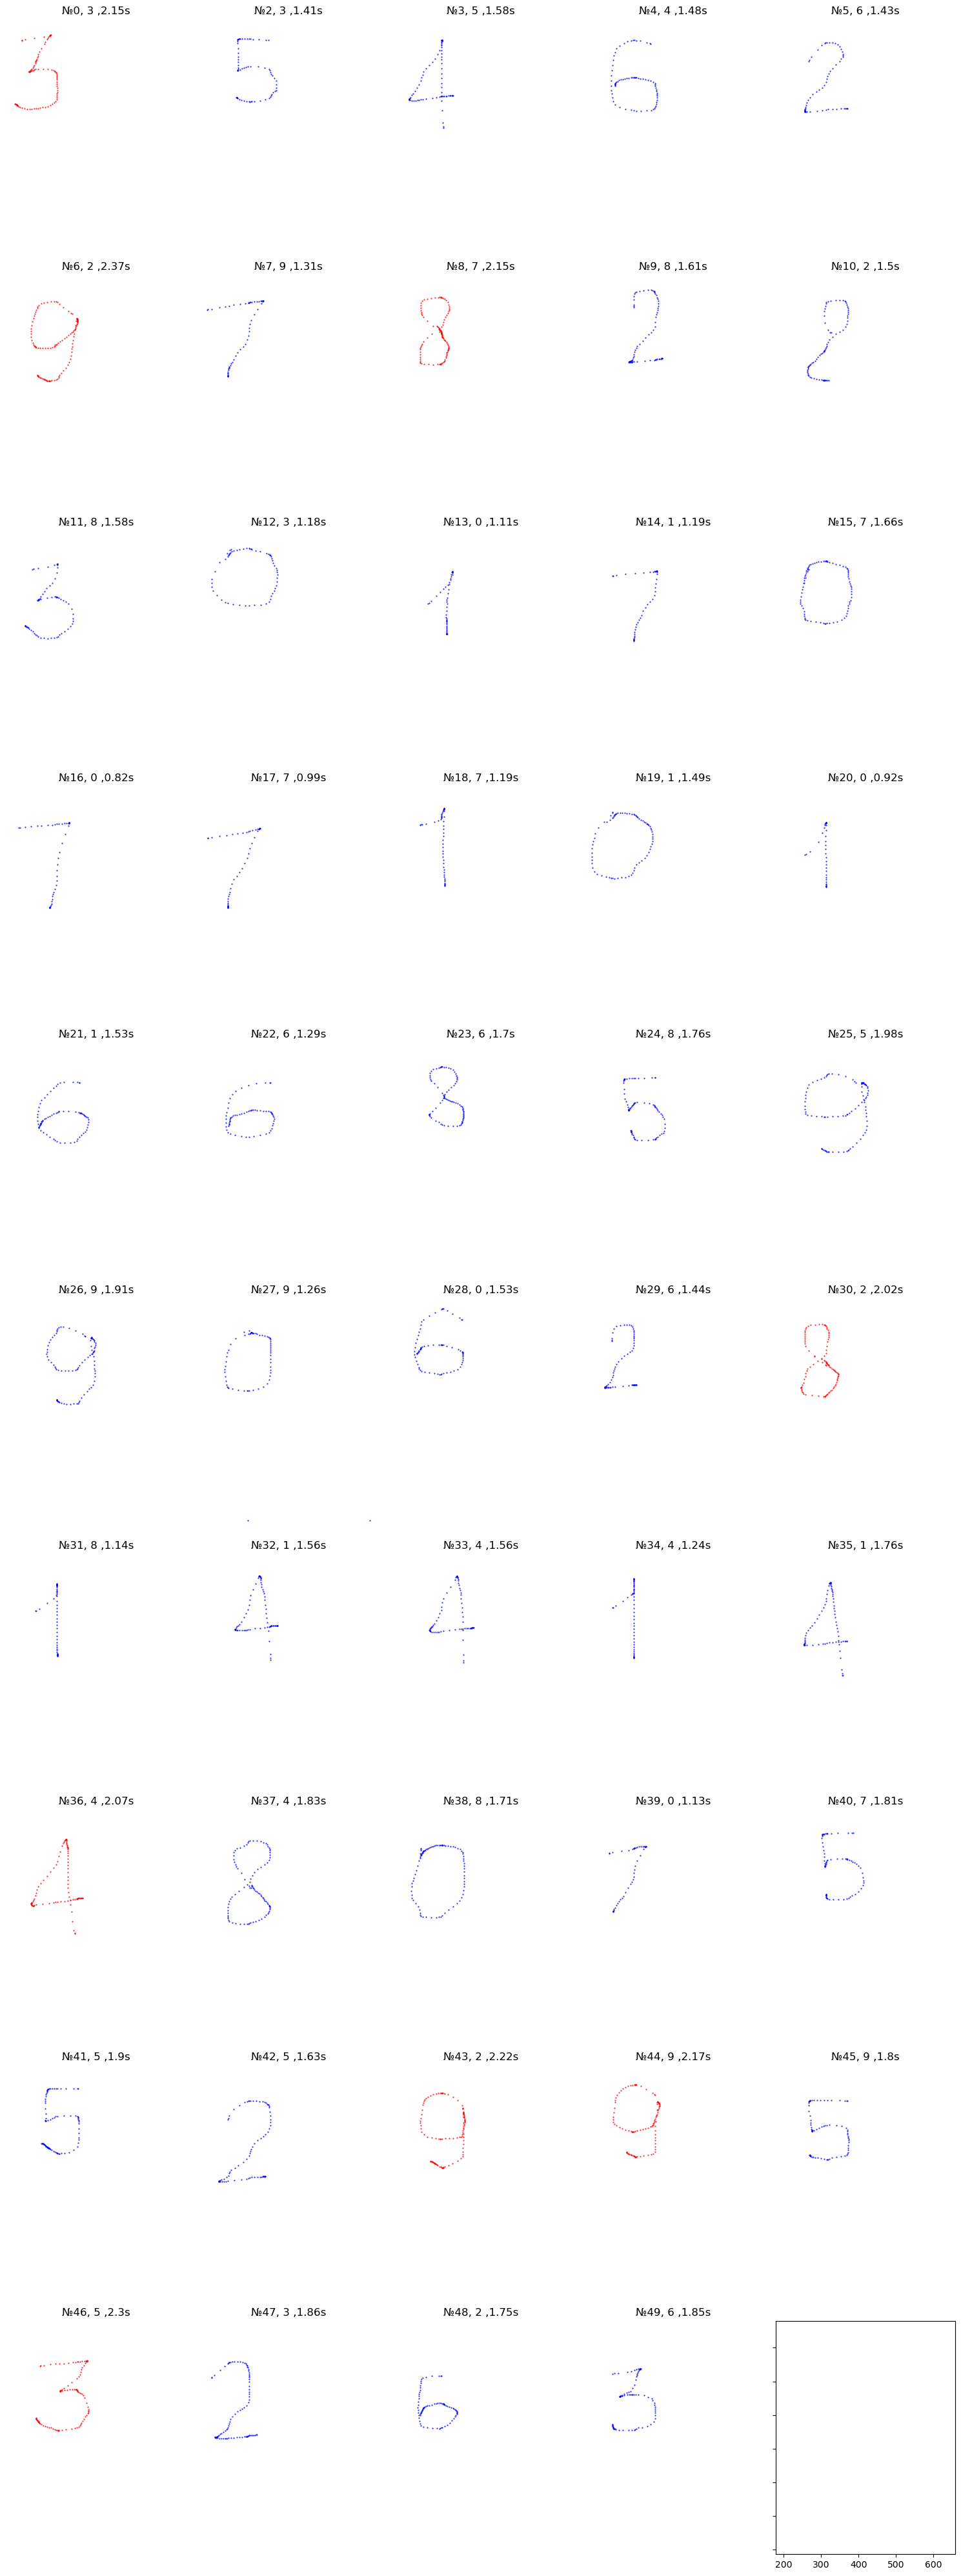

In [168]:
trials_times=[]  #продолжительности каждого испытания

df_motion.Epoch.unique()
fig, axx = plt.subplots(10,5, sharex=True, sharey=True, figsize=(15,40) )
for ia, (ep, group) in enumerate(df_motion.groupby('Epoch')):

    trial_duration=round(group['ts'].values[-1]-group['ts'].values[0],2) #длительность испытания - разница между последней и первой метками
    trials_times.append(trial_duration)
    
    subtitle='№'+str(ep) +', '+str(df_protocol['Digit_text'].values[ia])+' ,'+str(trial_duration)+'s'
    #заголовок графика - номер эпохи; цифра, которую писал испытуемый; длительность 
    
    color='r' if trial_duration>2 else 'b' #красный цвет, если дольше 2 секунд, иначе - синий
    
    plt.sca(axx.reshape(-1)[ia]) #выбираем график, соотв. текущей эпохе
    plt.plot(*(group.loc[:, ['X', 'Y']].values.T), color+'.', ms=1)
    # * - распаковака массива в 2 отдельных - для Х и для У. выбираем значения соотв  х и у и транспонируем. цвет точек (красный или синий). размер маркара
    plt.axis(False) 
    plt.title(subtitle)
plt.gca().invert_yaxis()
plt.tight_layout()

Возможно, для S104 стоит взять не 2 секунды, а 2.50

S105 1 рисунок пропущен, съехало на 1, надо что-то подвинуть и удалить

### Добавление пропущенного числа для S105, 5-я сессия

In [174]:
# Загружаю из 4-й сессии df_motion, беру оттуда "тройку", чтобы вставить на первый индекс в 5-1 сессии
df_motion_1=trials=pd.read_csv(subject+'/Preprocessed/'+'1'+'/trials_processed.csv',sep=';')
df_protocol_1=pd.read_excel('8_Sessions/Digits_Tyumen_'+'1'+'.xlsx')

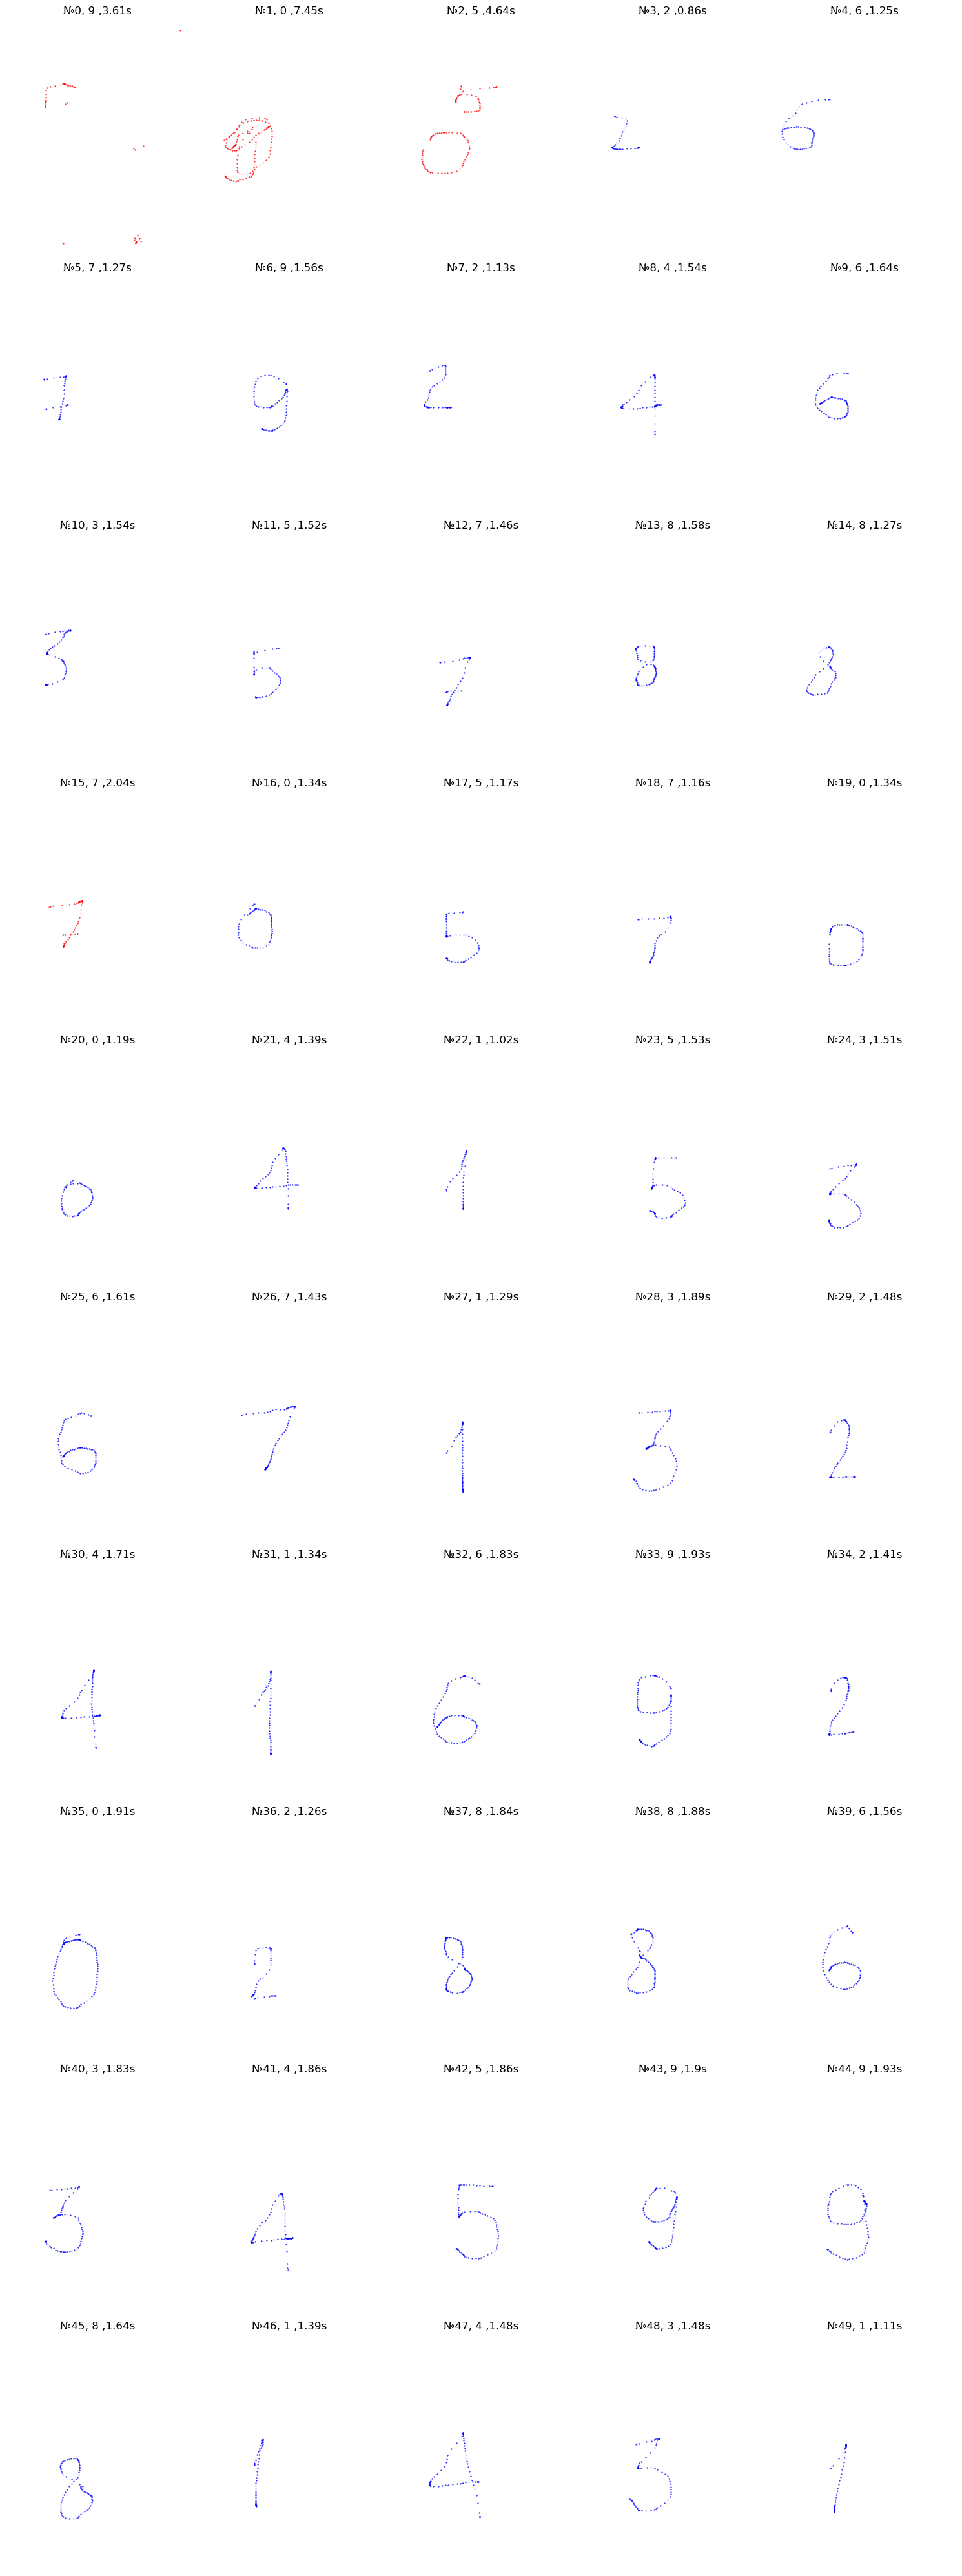

In [176]:
trials_times=[]  #продолжительности каждого испытания

df_motion_1.Epoch.unique()
fig, axx = plt.subplots(10,5, sharex=True, sharey=True, figsize=(15,40) )
for ia, (ep, group) in enumerate(df_motion_1.groupby('Epoch')):

    trial_duration=round(group['ts'].values[-1]-group['ts'].values[0],2) #длительность испытания - разница между последней и первой метками
    trials_times.append(trial_duration)
    
    subtitle='№'+str(ep) +', '+str(df_protocol_1['Digit_text'].values[ia])+' ,'+str(trial_duration)+'s'
    #заголовок графика - номер эпохи; цифра, которую писал испытуемый; длительность 
    
    color='r' if trial_duration>2 else 'b' #красный цвет, если дольше 2 секунд, иначе - синий
    
    plt.sca(axx.reshape(-1)[ia]) #выбираем график, соотв. текущей эпохе
    plt.plot(*(group.loc[:, ['X', 'Y']].values.T), color+'.', ms=1)
    # * - распаковака массива в 2 отдельных - для Х и для У. выбираем значения соотв  х и у и транспонируем. цвет точек (красный или синий). размер маркара
    plt.axis(False) 
    plt.title(subtitle)
plt.gca().invert_yaxis()
plt.tight_layout()

Подходит №40 

In [204]:
row_to_insert = df_motion_1[df_motion_1['Epoch'] == 40].copy()

In [208]:
row_to_insert['Epoch'] = 1

In [210]:
row_to_insert

,Unnamed: 0,INPUT,ts,ResetCounter,X,Y,Epoch
2899,2899,/dev/input/event0:,348.160004,160,213,381.0,1
2900,2900,/dev/input/event0:,348.260126,160,220,381.0,1
2901,2901,/dev/input/event0:,348.277078,160,237,379.0,1
2902,2902,/dev/input/event0:,348.293806,160,253,378.0,1
2903,2903,/dev/input/event0:,348.310458,160,264,376.0,1
...,...,...,...,...,...,...,...
2981,2981,/dev/input/event0:,349.903969,160,200,556.0,1
2982,2982,/dev/input/event0:,349.920762,160,200,554.0,1
2983,2983,/dev/input/event0:,349.954468,160,200,553.0,1
2984,2984,/dev/input/event0:,349.971344,160,200,554.0,1


In [212]:
missing_index = 1 

In [214]:
updated_df_motion = pd.concat([
    df_motion.iloc[:missing_index],  
    row_to_insert,            
    df_motion.iloc[missing_index:]  
]).reset_index(drop=True)  

In [239]:
updated_df_motion = updated_df_motion.drop(columns=['Unnamed: 0'])

In [241]:
updated_df_motion

,INPUT,ts,ResetCounter,X,Y,Epoch
0,/dev/input/event0:,0.000000,0,220,384.0,0
1,/dev/input/event0:,348.160004,160,213,381.0,1
2,/dev/input/event0:,348.260126,160,220,381.0,1
3,/dev/input/event0:,348.277078,160,237,379.0,1
4,/dev/input/event0:,348.293806,160,253,378.0,1
...,...,...,...,...,...,...
3996,/dev/input/event0:,424.952691,196,257,633.0,49
3997,/dev/input/event0:,424.969573,196,257,631.0,49
3998,/dev/input/event0:,424.986298,196,257,630.0,49
3999,/dev/input/event0:,425.003068,196,257,629.0,49


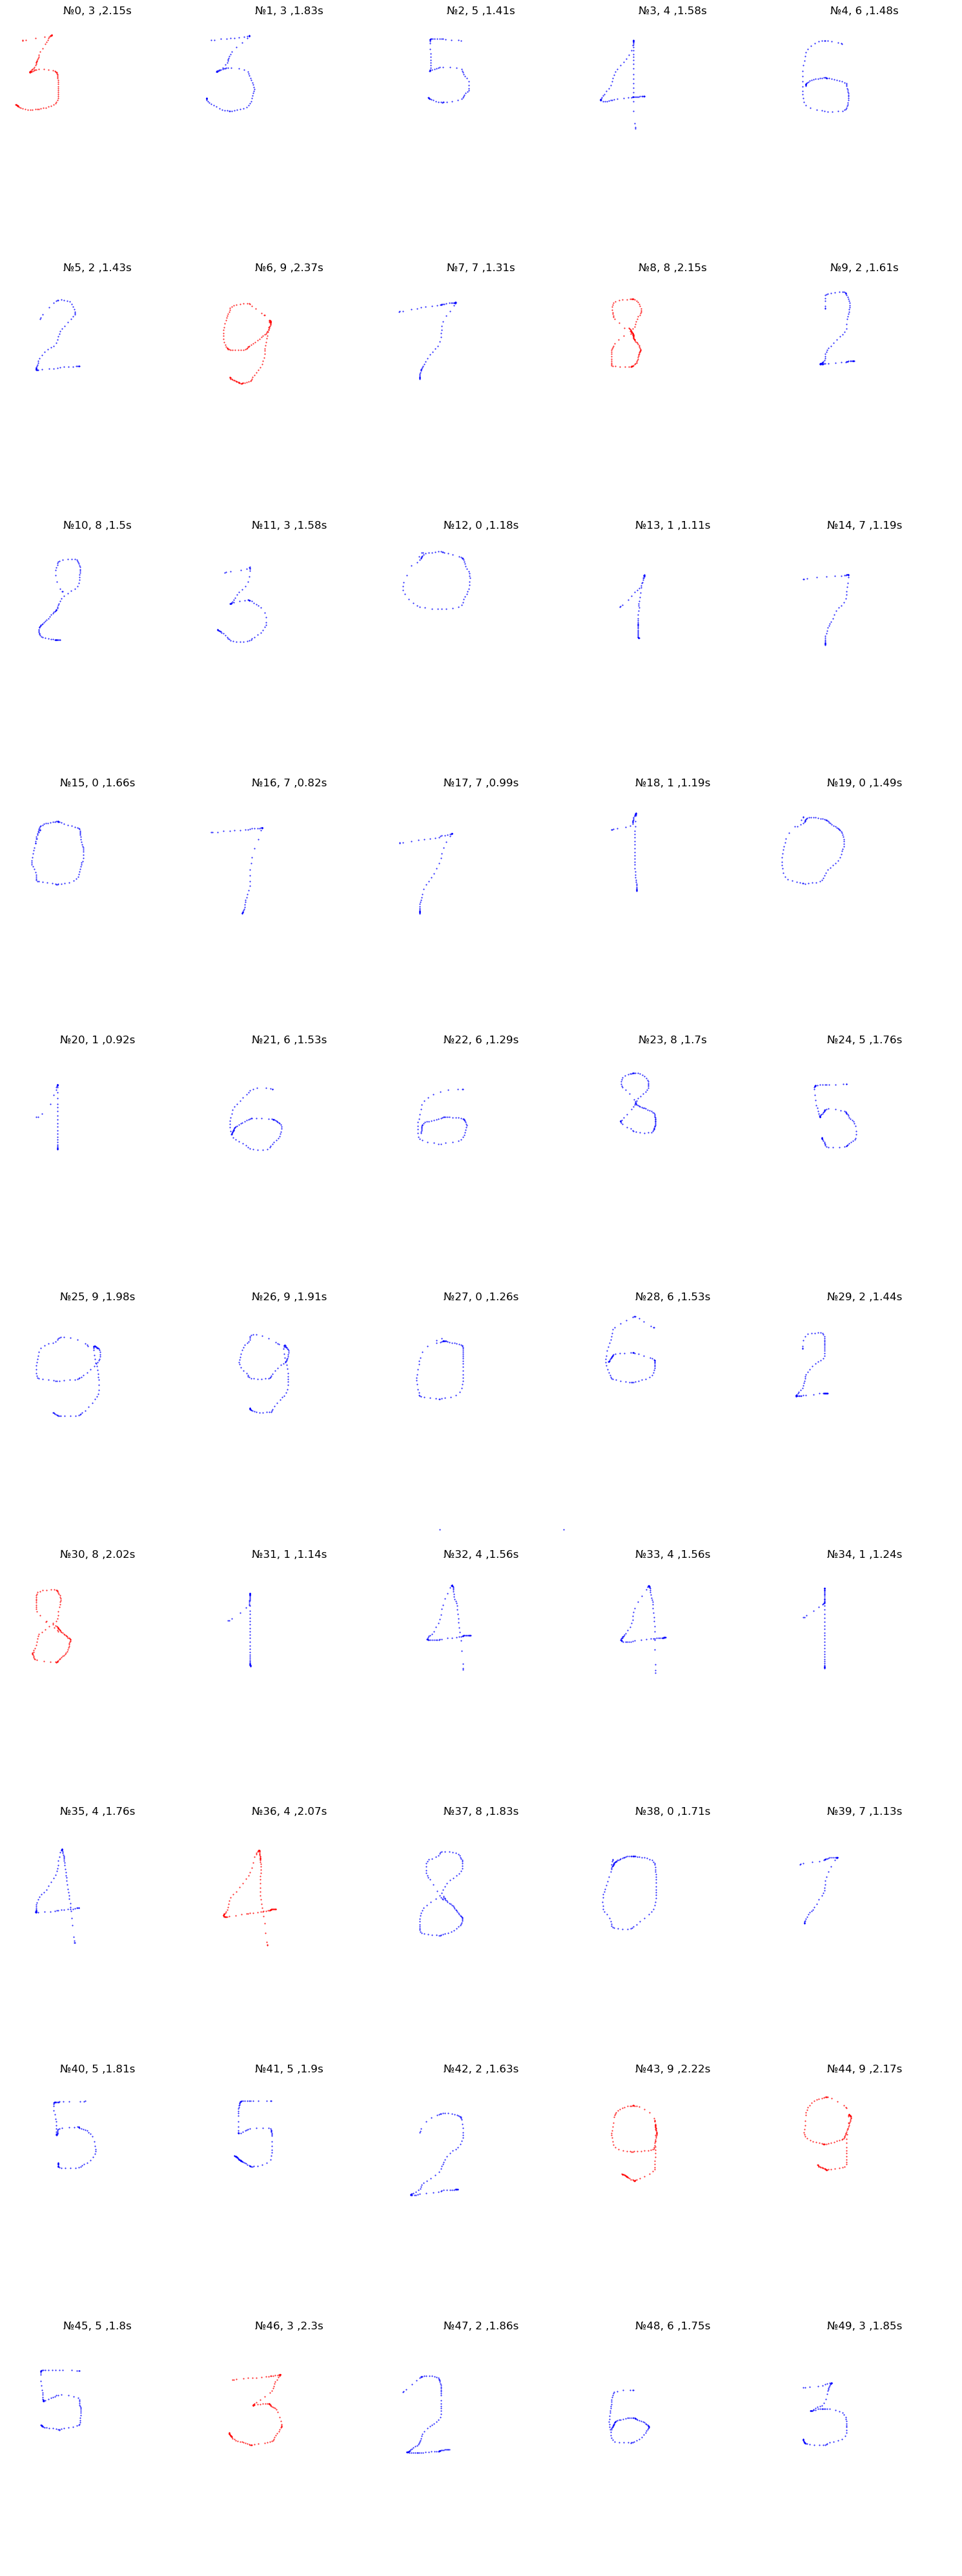

In [243]:
trials_times=[]  #продолжительности каждого испытания

updated_df_motion.Epoch.unique()
fig, axx = plt.subplots(10,5, sharex=True, sharey=True, figsize=(15,40) )
for ia, (ep, group) in enumerate(updated_df_motion.groupby('Epoch')):

    trial_duration=round(group['ts'].values[-1]-group['ts'].values[0],2) #длительность испытания - разница между последней и первой метками
    trials_times.append(trial_duration)
    
    subtitle='№'+str(ep) +', '+str(df_protocol['Digit_text'].values[ia])+' ,'+str(trial_duration)+'s'
    #заголовок графика - номер эпохи; цифра, которую писал испытуемый; длительность 
    
    color='r' if trial_duration>2 else 'b' #красный цвет, если дольше 2 секунд, иначе - синий
    
    plt.sca(axx.reshape(-1)[ia]) #выбираем график, соотв. текущей эпохе
    plt.plot(*(group.loc[:, ['X', 'Y']].values.T), color+'.', ms=1)
    # * - распаковака массива в 2 отдельных - для Х и для У. выбираем значения соотв  х и у и транспонируем. цвет точек (красный или синий). размер маркара
    plt.axis(False) 
    plt.title(subtitle)
plt.gca().invert_yaxis()
plt.tight_layout()

попробую тоже брать 2.5 для S105

## Сохраняем

In [223]:
code

'5'

In [225]:
subject

'S105'

In [227]:
df_motion.to_csv(subject+'/Preprocessed/'+code+'/trials_processed.csv', sep=';')
marks.to_csv(subject+'/Preprocessed/'+code+'/marks_processed.csv', sep=';')

In [245]:
#S105
updated_df_motion.to_csv(subject+'/Preprocessed/'+code+'/trials_processed.csv', sep=';')
marks.to_csv(subject+'/Preprocessed/'+code+'/marks_processed.csv', sep=';')